In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import os
import re
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df = pd.read_csv("data.csv")
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Text,Generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517482 entries, 0 to 517481
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Text       517482 non-null  object
 1   Generated  517482 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


In [20]:
print(f"Maximum sequence length: {df.Text.apply(len).max()}")
print(f"Most frequent sequence length: {df.Text.apply(len).mode()[0]}")
print(f"Mean sequence length: {df.Text.apply(len).mean()}")

Maximum sequence length: 18322
Most frequent sequence length: 1974
Mean sequence length: 2262.9922915193188


<Axes: title={'center': 'Histogram of question length'}, ylabel='Frequency'>

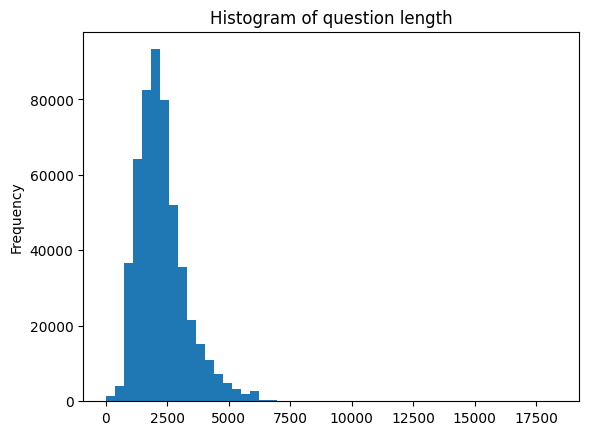

In [21]:
df.Text.apply(len).plot(kind='hist', bins=50, title="Histogram of question length")

In [22]:
stop = stopwords.words('english')

def cleaning(text):
    text = re.sub(r'[\W\d]+', ' ', text.lower()).strip()
    text = ' '.join([word for word in text.split() if word not in stop])
    return text

df["Text"] = df["Text"].apply(cleaning)
df.head()

,Text,Generated
0,cars cars around since became famous henry for...,0
1,transportation large necessity countries world...,0
2,america love affair vehicles seems cooling say...,0
3,often ride car drive one motor vehicle work st...,0
4,cars wonderful thing perhaps one worlds greate...,0


In [ ]:
lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

df["Text"] = df["Text"].apply(lemmatize_sentence)
df.head()

In [ ]:
output_csv = "cleaned_lemmatized_data.csv"
df.to_csv(output_csv, index=False)
print(f"DataFrame salvato nel file {output_csv}")

In [ ]:
df = pd.read_csv("cleaned_data.csv")


maxlen = 7500
max_features=50000

# Tokenizer setup
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X_nn = tf.keras.utils.pad_sequences(sequences, maxlen=maxlen)

# Label encoding
# label_encoder = LabelEncoder()
# Y_nn = label_encoder.fit_transform(df['Generated'])
Y_nn = df['Generated']


# cleaned_df = tf.data.Dataset.from_tensor_slices((X_nn, Y_nn))

# Trasforma il dataset con la funzione di mappatura
# cleaned_df = cleaned_df.map(vectorize_text)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0


2024-12-03 16:52:19.152057: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15524430000 exceeds 10% of free system memory.


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0


2024-12-03 16:53:53.300565: I tensorflow/core/common_runtime/placer.cc:162] components_0: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:53:53.300732: I tensorflow/core/common_runtime/placer.cc:162] components_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:53:53.301173: I tensorflow/core/common_runtime/placer.cc:162] TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:53:53.301193: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


components_0: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
components_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [10]:
# Dividi il dataset in train, validation e test
dataset_size = len(df)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

# cleaned_df = cleaned_df.shuffle(buffer_size=dataset_size, seed=42)

train_dataset = cleaned_df.take(train_size)
remaining_dataset = cleaned_df.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

batch_size = 512  # Definisci il batch size una volta
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Verifica i dati
for text, label in train_dataset.take(5):
    print("Text:", text.numpy())
    print("Label:", label.numpy())

input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:15.714903: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:15.715047: I tensorflow/core/common_runtime/placer.cc:162] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:15.715068: I tensorflow/core/common_runtime/placer.cc:162] TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:15.715091: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
SkipDataset: (SkipDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:16.888981: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:16.889131: I tensorflow/core/common_runtime/placer.cc:162] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:16.889147: I tensorflow/core/common_runtime/placer.cc:162] SkipDataset: (SkipDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:16.889158: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:17.154153: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:17.154232: I tensorflow/core/common_runtime/placer.cc:162] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:17.154257: I tensorflow/core/common_runtime/placer.cc:162] TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:17.154276: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
SkipDataset: (SkipDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:17.384613: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:17.384698: I tensorflow/core/common_runtime/placer.cc:162] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:17.384720: I tensorflow/core/common_runtime/placer.cc:162] SkipDataset: (SkipDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:17.384734: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:19.420041: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.420123: I tensorflow/core/common_runtime/placer.cc:162] batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.420136: I tensorflow/core/common_runtime/placer.cc:162] drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.420152: I tensorflow/core/common_runtime/placer.cc:162] BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.420163: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:19.641026: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.641088: I tensorflow/core/common_runtime/placer.cc:162] batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.641100: I tensorflow/core/common_runtime/placer.cc:162] drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.641117: I tensorflow/core/common_runtime/placer.cc:162] BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.641128: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:19.884969: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.885052: I tensorflow/core/common_runtime/placer.cc:162] batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.885066: I tensorflow/core/common_runtime/placer.cc:162] drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.885086: I tensorflow/core/common_runtime/placer.cc:162] BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:19.885099: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:20.093268: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:20.093332: I tensorflow/core/common_runtime/placer.cc:162] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:20.093351: I tensorflow/core/common_runtime/placer.cc:162] TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-03 16:54:20.093365: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0


2024-12-03 16:54:20.460771: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15524430000 exceeds 10% of free system memory.


Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Text: [[   0    0    0 ...  186    2   35]
 [   0    0    0 ...    3   76  827]
 [   0    0    0 ...  169   10  435]
 ...
 [   0    0    0 ...   32  466  281]
 [   0    0    0 ...  347    5 2024]
 [   0    0    0 ...   59    4   54]]
Label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [4]:
EMBEDDING_FILE = 'glove.6B.50d.txt'
word_index = tokenizer.word_index
embeddings_index = {}

# Apri il file di embedding
with open(EMBEDDING_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            # Ignora righe che non possono essere convertite in numeri
            print(f"Riga ignorata per il word embedding: {line}")

# Assicurati che tutti i valori siano numpy array di dimensione coerente
valid_embeddings = [v for v in embeddings_index.values() if v.shape == (50,)]  # 50 è la dimensione di GloVe
if not valid_embeddings:
    raise ValueError("Non ci sono embeddings validi!")

# Ottieni la media e la deviazione standard degli embeddings
all_embs = np.stack(valid_embeddings)
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

# Genera una matrice di embedding
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix)

[[ 0.79511496  0.56470249  0.24699648 ...  0.72842256  0.18338766
   1.03411573]
 [-0.31503998 -0.52615047 -0.51720554 ... -0.00702405  0.69443125
   0.94769547]
 [ 0.41800001  0.24968    -0.41242    ... -0.18411    -0.11514
  -0.78580999]
 ...
 [ 0.29969001 -0.31439    -1.23829997 ... -0.028876    0.22649001
  -1.66719997]
 [ 0.92031002 -0.16452    -0.43863001 ... -0.71149999  0.90157998
  -1.42830002]
 [ 0.46755999 -0.74646997 -0.092432   ... -0.19106001 -0.82644999
  -0.030229  ]]


In [24]:
def sequence_model(maxlen, max_features, embed_size, metrics):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(maxlen,)),  # la virgola per creare una tupla
        tf.keras.layers.Embedding(
            input_dim=max_features, 
            output_dim=embed_size, 
            #weights=[embedding_matrix], 
            trainable=True
        ),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences = True)),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, epsilon=0.01)
    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=metrics
    )
    return model


In [ ]:
METRICS = [
    tf.keras.metrics.AUC(name='roc-auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall")
          ]

embed_size = 300

model = sequence_model(maxlen, max_features, embed_size, METRICS)
reduceOnPlateu = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

hist = model.fit(
    train_dataset, 
    epochs=50, 
    validation_data=val_dataset, 
    callbacks=[reduceOnPlateu],
    shuffle=False
)


Epoch 1/50
   1/3235 ━━━━━━━━━━━━━━━━━━━━ 10:58:28 12s/step - accuracy: 1.0000 - loss: 0.6167 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.0000e+00

KeyboardInterrupt: 

In [28]:
def plot(history, *metrics):
    
    n_plots = len(metrics)
    
    fig, axs = plt.subplots(1,n_plots, figsize=(18, 5))

    hist = history.history

    for ax, metric in zip(axs, metrics):
        ax.plot(np.clip(hist[metric], 0, 1))
        ax.plot(np.clip(hist["val_"+metric], 0, 1))
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)

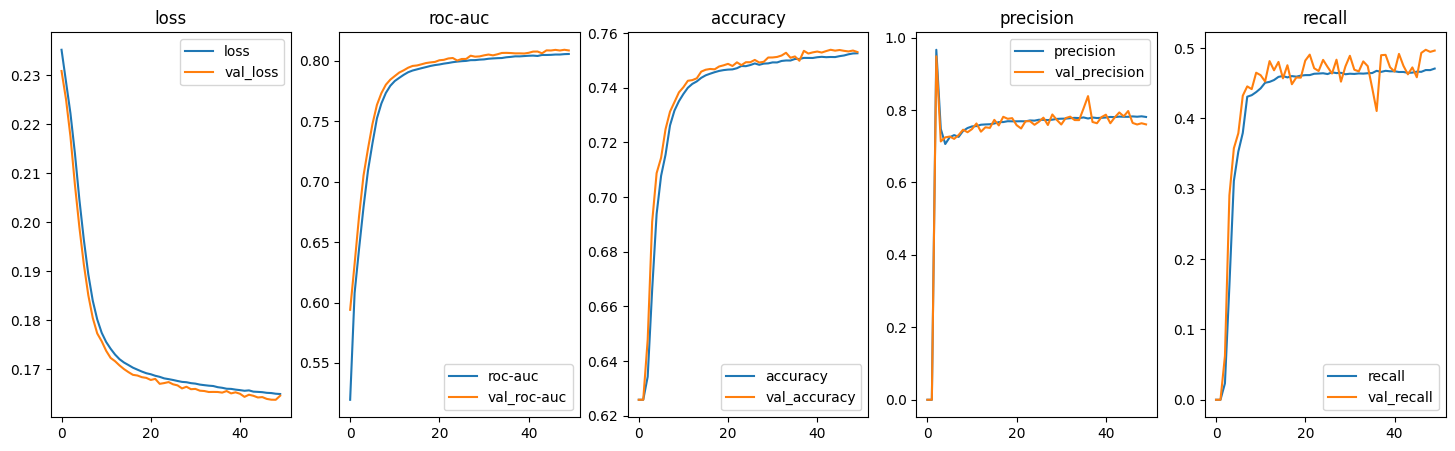

In [29]:
plot(hist, 'loss', 'roc-auc', 'accuracy', 'precision', "recall")

In [45]:
preds = model.predict(X_test)
binary_preds = (preds >= 0.5).astype(int)

accuracy = accuracy_score(y_test, binary_preds)
precision = precision_score(y_test, binary_preds)
recall = recall_score(y_test, binary_preds)
roc_auc = roc_auc_score(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print()
print("Confusion Matrix:")
print(confusion_matrix(y_test, binary_preds))

1618/1618 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.7496
Precision: 0.7841
Recall: 0.4563
ROC AUC: 0.8013

Confusion Matrix:
[[29954  2432]
 [10528  8835]]
